IMPORTS & SETUP

In [ ]:
### IMPORTS ###

import os
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pickle
from pathlib import Path
import random
from config import * 
from xyzcoords import load_coordinates, fix_outlier_coordinates, plot_3d_adj_matrix
from scattering import create_task_labels, load_and_reshape_scattering_coeffs
from dataprep import (
    load_fnirs_data, verify_data_match, generate_scatter_coefficients,
    combine_fnirs_data, combine_scattering_data, prepare_data, prepare_data_for_autoencoder
)
from models import (
    BrainStateClassifier, BrainStateAutoencoder, BrainStateFullModel,
    AttentionAutoencoder, AttentionFullModel
)
from train import (
    train_and_evaluate, run_cross_validation, 
    train_autoencoder, train_attention_model
)
from visualization import (
    compare_results, compare_all_methods, visualize_latent_space,
    plot_attention_weights, compare_attention_with_pca
)


# Keep for now bedcause imports are just being weird
import train
importlib.reload(train)
from train import (
    train_and_evaluate, run_cross_validation, 
    train_autoencoder, train_attention_model
)
import visualization
importlib.reload(visualization)
from visualization import (
    load_latent_embeddings
)
#MANUALLY IMPORTING SCATTERING_DATA BECAUSE CONFIG FILE BEING WEIRD. IDK WHY.
fnirs_data = "/Users/judesack/THESIS_CODE/GSTH/notebooks/baseline_data/combined_fnirs_data.csv"
scattering_data = "/Users/judesack/THESIS_CODE/GSTH/notebooks/scattering_coefficients/MLP_data_new/combined_data.csv"

In [ ]:
### DATA LOADING ###

# XYZ coords
subject_probe_coords, subject_channel_coords = load_coordinates()
print(f"Found coordinates for {len(subject_channel_coords)} subjects")
subject_channel_coords = fix_outlier_coordinates(subject_channel_coords)

# fNIRS data
subject_data_matrices = load_fnirs_data()

# Match between coords and fNIRS
match_ok = verify_data_match(subject_channel_coords, subject_data_matrices)


Processed 20 subjects
Probe matrix shape: (32, 3)
Channel matrix shape: (48, 3)
Found coordinates for 20 subjects
Replacing coords for Subject 15052902, Node 0:
  Before: [-209.435   91.875  100.625]
  After: [ 70.2175 -52.3625  28.575 ]
Replacing coords for Subject 15052902, Node 3:
  Before: [-203.655  108.15   108.975]
  After: [ 70.2175 -52.3625  28.575 ]
Excluding Subject 15081202sub1: shape (750, 48) ≠ (7850, 48)
Excluding Subject 15072703: shape (750, 48) ≠ (7850, 48)

Processed 17 subjects
Missing in fNIRS data: {'15072703', '15081202sub1', '14073001'}


In [ ]:
### SCATTERING COEFFICIENTS ###
run_coefficient_generation = False  

if run_coefficient_generation:
    print("Generating scattering coefficients...")
    generate_scatter_coefficients(subject_channel_coords, subject_data_matrices)
else:
    print("Skipping coefficient generation (already done)")

Skipping coefficient generation (already done)


In [ ]:
### COMBINING DATASETS ###

if not os.path.exists(fnirs_data):
    print("Creating combined fNIRS data file...")
    fnirs_df = combine_fnirs_data(DATA_DIR, fnirs_data)
else:
    print(f"Combined fNIRS data already exists at {fnirs_data}")
    fnirs_df = pd.read_csv(fnirs_data)

if not os.path.exists(scattering_data):
    print("Creating combined scattering coefficients file...")
    scat_df = combine_scattering_data("scattering_coefficients/MLP_data_new", scattering_data)
else:
    print(f"Combined scattering data already exists at {scattering_data}")
    scat_df = pd.read_csv(scattering_data)

#Expect (133450, 51) & (133450, 771). 3 metadata colunms.  
print(f"Raw fNIRS data shape: {fnirs_df.shape}")
print(f"Scattering data shape: {scat_df.shape}")

Combined fNIRS data already exists at /Users/judesack/THESIS_CODE/GSTH/notebooks/baseline_data/combined_fnirs_data.csv


/var/folders/wq/qc5c6y6n0y96dck20g1j0dnw0000gn/T/ipykernel_12656/1090436214.py:7: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  fnirs_df = pd.read_csv(fnirs_data)


Combined scattering data already exists at /Users/judesack/THESIS_CODE/GSTH/notebooks/scattering_coefficients/MLP_data_new/combined_data.csv
Raw fNIRS data shape: (133450, 51)
Scattering data shape: (133450, 771)


/var/folders/wq/qc5c6y6n0y96dck20g1j0dnw0000gn/T/ipykernel_12656/1090436214.py:14: DtypeWarning: Columns (768) have mixed types. Specify dtype option on import or set low_memory=False.
  scat_df = pd.read_csv(scattering_data)


In [ ]:
### BASELINE MLP CLASSIFIER ###
run_baseline_train = False

if run_baseline_train:
    print("\n--- TRAINING ON RAW FNIRS DATA --- ")
    
    print("\n--- SUBJECT WITHHOLDING ---")
    train_loader, test_loader = prepare_data(
        data_path=fnirs_data,
        feature_prefix="node_",
        include_metadata=False,
        split_type="subject" 
    )
    fnirs_model = BrainStateClassifier(input_dim=48)
    model, preds, labels, metrics = train_and_evaluate(
        train_loader=train_loader,
        test_loader=test_loader,
        model=fnirs_model,
        num_epochs=50
    )

    print("\n--- TIME WITHHOLDING ---")
    train_loader, test_loader = prepare_data(
        data_path=fnirs_data,
        feature_prefix="node_",
        include_metadata=False,
        split_type="time" 
    )
    fnirs_model = BrainStateClassifier(input_dim=48)
    model, preds, labels, metrics = train_and_evaluate(
        train_loader=train_loader,
        test_loader=test_loader,
        model=fnirs_model,
        num_epochs=50  # 25 might be enough tbh
    )
else:
    print("Skipping baseline model training")

Skipping baseline model training


In [ ]:
### SCATTERING MLP CLASSIFIER ###
run_scattering_train = False

if run_scattering_train:
    print("\n--- TRAINING ON SCATTERING COEFFICIENTS --- ")

    print("\n--- SUBJECT WITHHOLDING ---")
    train_loader, test_loader = prepare_data(
        data_path=scattering_data,
        feature_prefix="feature_",
        include_metadata=False,
        split_type="subject"
    )
    scattering_model = BrainStateClassifier(input_dim=768)
    model_subject, preds_subject, labels_subject, metrics_subject = train_and_evaluate(
        train_loader=train_loader,
        test_loader=test_loader,
        model=scattering_model,
        num_epochs=50
    )
    print("\n--- TIME WITHHOLDING ---")
    train_loader, test_loader = prepare_data(
        data_path=scattering_data,
        feature_prefix="feature_",
        include_metadata=False,
        split_type="time" 
    )
    scattering_model = BrainStateClassifier(input_dim=768)
    model_time, preds_time, labels_time, metrics_time = train_and_evaluate(
        train_loader=train_loader,
        test_loader=test_loader,
        model=scattering_model,
        num_epochs=50
    )
else:
    print("Skipping scattering model training")

Skipping scattering model training



--- RAW FNIRS CROSS-VALIDATION ---

- SUBJECT SPLIT -

=== Trial 1/1 ===


/Users/judesack/THESIS_CODE/FINAL_THESIS/dataprep.py:182: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)



Split: subject — train 100800, test 21600
Using cpu
Started training...
Epoch 10/50: Loss=0.1164, Acc=95.81%
Epoch 20/50: Loss=0.0872, Acc=96.95%
Epoch 30/50: Loss=0.0765, Acc=97.34%
Epoch 40/50: Loss=0.0697, Acc=97.56%
Epoch 50/50: Loss=0.0660, Acc=97.71%

Test Set Results:
              precision    recall  f1-score   support

        Rest      0.579     0.829     0.682     12000
      Improv      0.374     0.098     0.155      4800
       Scale      0.223     0.147     0.177      4800

    accuracy                          0.515     21600
   macro avg      0.392     0.358     0.338     21600
weighted avg      0.455     0.515     0.453     21600


=== Cross-Validation Results (subject split) ===
Mean Accuracy: 0.5150 ± 0.0000

- TIME SPLIT -

=== Trial 1/1 ===


/Users/judesack/THESIS_CODE/FINAL_THESIS/dataprep.py:182: DtypeWarning: Columns (48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)



Split: time — train 97920, test 24480
Using cpu
Started training...
Epoch 10/50: Loss=0.1095, Acc=96.10%
Epoch 20/50: Loss=0.0869, Acc=96.92%
Epoch 30/50: Loss=0.0710, Acc=97.49%
Epoch 40/50: Loss=0.0666, Acc=97.73%
Epoch 50/50: Loss=0.0624, Acc=97.86%

Test Set Results:
              precision    recall  f1-score   support

        Rest      0.783     0.761     0.772     13600
      Improv      0.465     0.938     0.622      4080
       Scale      0.731     0.327     0.452      6800

    accuracy                          0.670     24480
   macro avg      0.660     0.675     0.615     24480
weighted avg      0.716     0.670     0.658     24480


=== Cross-Validation Results (time split) ===
Mean Accuracy: 0.6698 ± 0.0000

--- SCATTERING CROSS-VALIDATION ---

- SUBJECT SPLIT -

=== Trial 1/1 ===


/Users/judesack/THESIS_CODE/FINAL_THESIS/dataprep.py:182: DtypeWarning: Columns (768) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)



Split: subject — train 100800, test 21600
Using cpu
Started training...
Epoch 10/50: Loss=0.2598, Acc=90.17%
Epoch 20/50: Loss=0.2181, Acc=91.96%
Epoch 30/50: Loss=0.2028, Acc=92.66%
Epoch 40/50: Loss=0.1933, Acc=92.94%
Epoch 50/50: Loss=0.1880, Acc=93.24%

Test Set Results:
              precision    recall  f1-score   support

        Rest      0.554     0.896     0.685     12000
      Improv      0.107     0.045     0.064      4800
       Scale      0.108     0.003     0.006      4800

    accuracy                          0.509     21600
   macro avg      0.256     0.315     0.252     21600
weighted avg      0.356     0.509     0.396     21600


=== Cross-Validation Results (subject split) ===
Mean Accuracy: 0.5088 ± 0.0000

- TIME SPLIT -

=== Trial 1/1 ===


/Users/judesack/THESIS_CODE/FINAL_THESIS/dataprep.py:182: DtypeWarning: Columns (768) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)



Split: time — train 97920, test 24480
Using cpu
Started training...
Epoch 10/50: Loss=0.2830, Acc=89.07%
Epoch 20/50: Loss=0.2333, Acc=91.08%
Epoch 30/50: Loss=0.2146, Acc=92.01%
Epoch 40/50: Loss=0.2011, Acc=92.68%
Epoch 50/50: Loss=0.1990, Acc=92.77%

Test Set Results:
              precision    recall  f1-score   support

        Rest      0.679     0.676     0.677     13600
      Improv      0.449     0.636     0.526      4080
       Scale      0.501     0.379     0.432      6800

    accuracy                          0.587     24480
   macro avg      0.543     0.564     0.545     24480
weighted avg      0.591     0.587     0.584     24480


=== Cross-Validation Results (time split) ===
Mean Accuracy: 0.5869 ± 0.0000

Results saved to cross_validation_results.pkl


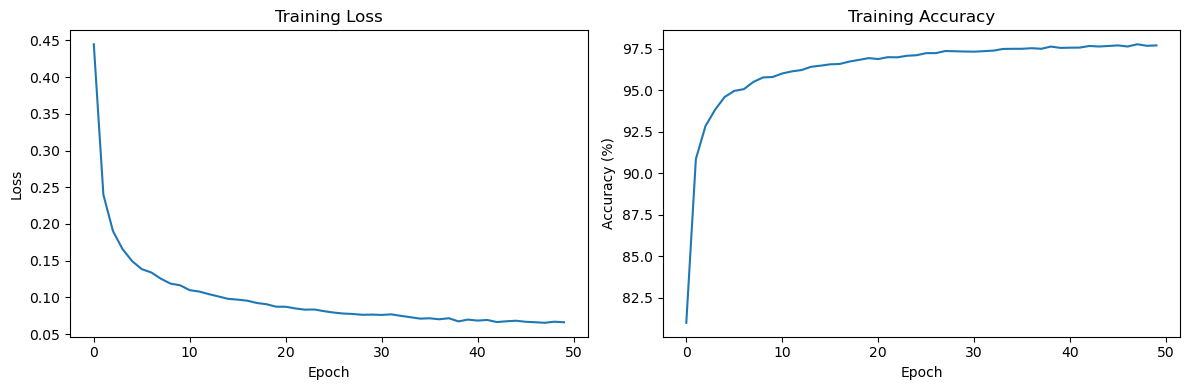

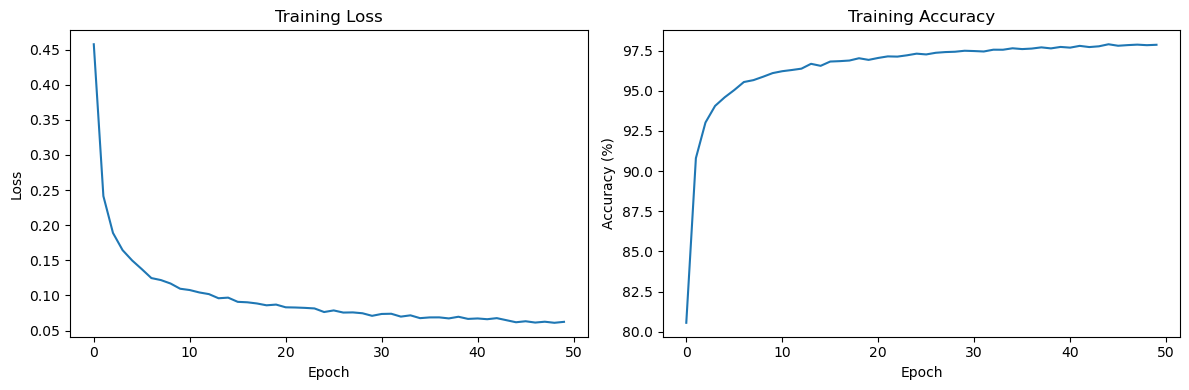

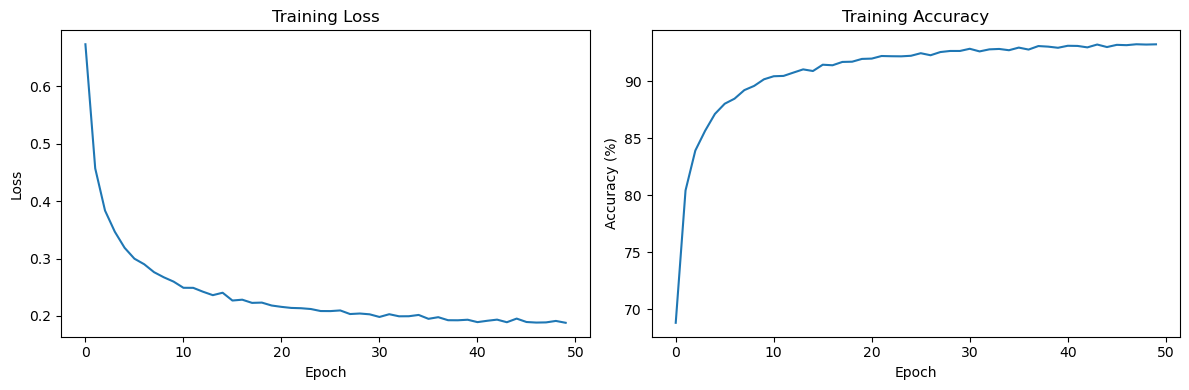

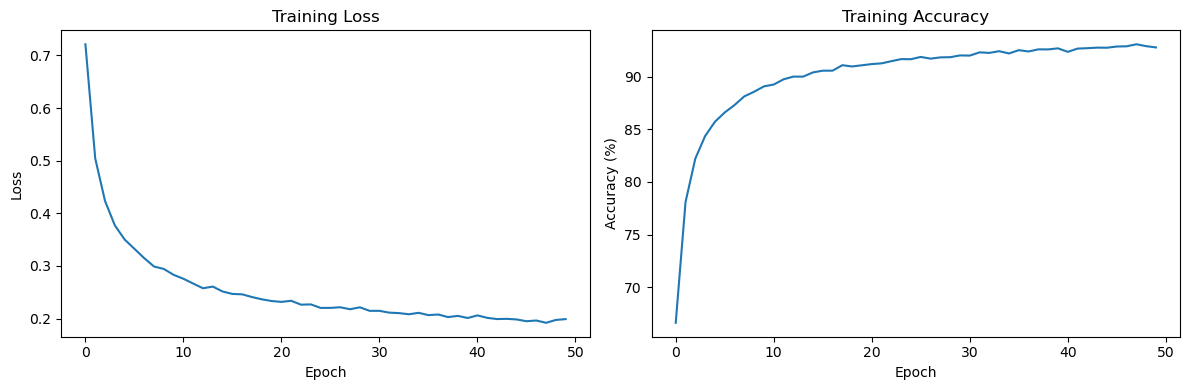

In [ ]:
### CROSS-VALIDATION (BASELINE V. SCATTERING) ###
run_crossval = True

if run_crossval:
    print("\n--- RAW FNIRS CROSS-VALIDATION ---")
    fnirs_results = {}
    for split_type in ["subject", "time"]:
        print(f"\n- {split_type.upper()} SPLIT -")
        fnirs_results[split_type] = run_cross_validation(
            data_path=fnirs_data,
            feature_prefix="node_",
            split_type=split_type,
            num_trials=1, #CHANGE BACK TO 5 FOR THESIS RUN.
            input_dim=48
        )
    
    print("\n--- SCATTERING CROSS-VALIDATION ---")
    scattering_results = {}
    for split_type in ["subject", "time"]:
        print(f"\n- {split_type.upper()} SPLIT -")
        scattering_results[split_type] = run_cross_validation(
            data_path=scattering_data,
            feature_prefix="feature_",
            split_type=split_type,
            num_trials=1,
            input_dim=768
        )

    with open('cross_validation_results.pkl', 'wb') as f:
        pickle.dump({
            'fnirs': fnirs_results,
            'scattering': scattering_results
        }, f)
    
    print("\nResults saved to cross_validation_results.pkl")

else:
    cv_file = 'cross_validation_results.pkl'
    if os.path.exists(cv_file):
        with open(cv_file, 'rb') as f:
            cv_results = pickle.load(f)
        print(f"Loaded existing cross-validation results from {cv_file}")
        
        #Summary
        fnirs_results = cv_results['fnirs']
        scattering_results = cv_results['scattering']
        print("\nSummary of cross-validation results:")
        print(f"Raw fNIRS (subject): {fnirs_results['subject']['mean_accuracy']:.4f} ± {fnirs_results['subject']['std_accuracy']:.4f}")
        print(f"Raw fNIRS (time): {fnirs_results['time']['mean_accuracy']:.4f} ± {fnirs_results['time']['std_accuracy']:.4f}")
        print(f"Scattering (subject): {scattering_results['subject']['mean_accuracy']:.4f} ± {scattering_results['subject']['std_accuracy']:.4f}")
        print(f"Scattering (time): {scattering_results['time']['mean_accuracy']:.4f} ± {scattering_results['time']['std_accuracy']:.4f}")
    else:
        print("No existing cross-validation results found")

In [49]:
### AUTOENCODER ###

run_autoencoder_train = True

if run_autoencoder_train:
    print("\n=== TRAINING AUTOENCODER === ")
    results = {}
    latent_dims = [8, 48] 
    
    for latent_dim in latent_dims:
        print(f"\n=== LATENT DIM: {latent_dim} ===")
        latent_results = {}

        print(f"\n--- SUBJECT WITHHOLDING ---")
        subject_train_loader, subject_test_loader, (subject_train_ids, subject_test_ids) = prepare_data_for_autoencoder(
            data_path=scattering_data,
            split_type="subject"
        )
        subject_model, subject_history = train_autoencoder(
            train_loader=subject_train_loader,
            test_loader=subject_test_loader,
            num_epochs=50,
            latent_dim=latent_dim,
            split_name=f"Subject-withheld (Latent: {latent_dim})"
        )
        torch.save({
            'model_state_dict': subject_model.state_dict(),
            'history': subject_history,
            'train_subjects': subject_train_ids,
            'test_subjects': subject_test_ids,
            'split_type': 'subject',
            'latent_dim': latent_dim
        }, os.path.join(extended_results_dir, f'subject_withheld_model_latent{latent_dim}.pth'))
        latent_results['subject'] = {
            'accuracy': subject_history['test_accuracy'],
        }
        

        print(f"\n--- TIME WITHHOLDING ---")
        time_train_loader, time_test_loader, (time_train_ids, time_test_ids) = prepare_data_for_autoencoder(
            data_path=scattering_data,
            split_type="time"
        )
        
        time_model, time_history = train_autoencoder(
            train_loader=time_train_loader,
            test_loader=time_test_loader,
            num_epochs=50, 
            latent_dim=latent_dim,
            split_name=f"Time-withheld (Latent: {latent_dim})"
        )
        torch.save({
            'model_state_dict': time_model.state_dict(),
            'history': time_history,
            'train_subjects': time_train_ids,
            'test_subjects': time_test_ids,
            'split_type': 'time',
            'latent_dim': latent_dim
        }, os.path.join(extended_results_dir, f'time_withheld_model_latent{latent_dim}.pth'))
        latent_results['time'] = {
            'accuracy': time_history['test_accuracy'],
        }
        results[latent_dim] = latent_results
    

    with open(os.path.join(extended_results_dir, 'latent_dimension_comparison.pkl'), 'wb') as f:
        pickle.dump(results, f)
    
    print("\n=== AUTOENCODER RESULTS SUMMARY ===")
    for latent_dim in latent_dims:
        print(f"\nLatent Dimension: {latent_dim}")
        print(f"  Subject-withheld accuracy: {results[latent_dim]['subject']['accuracy']:.2f}%")
        print(f"  Time-withheld accuracy: {results[latent_dim]['time']['accuracy']:.2f}%")

else:
    results_file = os.path.join(extended_results_dir, 'latent_dimension_comparison.pkl')
    if os.path.exists(results_file):
        with open(results_file, 'rb') as f:
            autoenc_results = pickle.load(f)
            
        print("\n=== LOADED AUTOENCODER RESULTS ===")
        for latent_dim in autoenc_results:
            print(f"\nLatent Dimension: {latent_dim}")
            print(f"  Subject-withheld accuracy: {autoenc_results[latent_dim]['subject']['accuracy']:.2f}%")
            print(f"  Time-withheld accuracy: {autoenc_results[latent_dim]['time']['accuracy']:.2f}%")
    else:
        print("No existing autoencoder results found")


=== TRAINING AUTOENCODER === 

=== LATENT DIM: 8 ===

--- SUBJECT WITHHOLDING ---


/Users/judesack/THESIS_CODE/FINAL_THESIS/dataprep.py:256: DtypeWarning: Columns (768) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


Using cpu device with latent dimension 8
Subject-withheld (Latent: 8) Epoch 10/50: Loss=0.4011 (R=0.1441, C=0.2571), Acc=90.29%
Subject-withheld (Latent: 8) Epoch 20/50: Loss=0.3399 (R=0.1470, C=0.1929), Acc=92.95%
Subject-withheld (Latent: 8) Epoch 30/50: Loss=0.3188 (R=0.1504, C=0.1684), Acc=94.10%
Subject-withheld (Latent: 8) Epoch 40/50: Loss=0.2985 (R=0.1516, C=0.1469), Acc=94.84%
Subject-withheld (Latent: 8) Epoch 50/50: Loss=0.2973 (R=0.1605, C=0.1368), Acc=95.26%
Subject-withheld (Latent: 8) Test Accuracy: 53.88%

Classification Report:
              precision    recall  f1-score   support

        Rest       0.57      0.91      0.70     12000
      Improv       0.25      0.10      0.14      4800
       Scale       0.63      0.05      0.10      4800

    accuracy                           0.54     21600
   macro avg       0.48      0.35      0.31     21600
weighted avg       0.51      0.54      0.44     21600


--- TIME WITHHOLDING ---


/Users/judesack/THESIS_CODE/FINAL_THESIS/dataprep.py:256: DtypeWarning: Columns (768) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


Using cpu device with latent dimension 8
Time-withheld (Latent: 8) Epoch 10/50: Loss=0.4077 (R=0.1487, C=0.2590), Acc=90.35%
Time-withheld (Latent: 8) Epoch 20/50: Loss=0.3478 (R=0.1493, C=0.1985), Acc=92.81%
Time-withheld (Latent: 8) Epoch 30/50: Loss=0.3302 (R=0.1534, C=0.1768), Acc=93.64%
Time-withheld (Latent: 8) Epoch 40/50: Loss=0.3145 (R=0.1596, C=0.1549), Acc=94.53%
Time-withheld (Latent: 8) Epoch 50/50: Loss=0.3044 (R=0.1590, C=0.1454), Acc=94.92%
Time-withheld (Latent: 8) Test Accuracy: 60.87%

Classification Report:
              precision    recall  f1-score   support

        Rest       0.68      0.76      0.72     13600
      Improv       0.49      0.79      0.60      4080
       Scale       0.48      0.19      0.28      6800

    accuracy                           0.61     24480
   macro avg       0.55      0.58      0.53     24480
weighted avg       0.60      0.61      0.58     24480


=== LATENT DIM: 48 ===

--- SUBJECT WITHHOLDING ---


/Users/judesack/THESIS_CODE/FINAL_THESIS/dataprep.py:256: DtypeWarning: Columns (768) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


Using cpu device with latent dimension 48
Subject-withheld (Latent: 48) Epoch 10/50: Loss=0.4092 (R=0.1587, C=0.2504), Acc=90.38%
Subject-withheld (Latent: 48) Epoch 20/50: Loss=0.3606 (R=0.1655, C=0.1950), Acc=92.89%
Subject-withheld (Latent: 48) Epoch 30/50: Loss=0.3540 (R=0.1827, C=0.1714), Acc=93.93%
Subject-withheld (Latent: 48) Epoch 40/50: Loss=0.3302 (R=0.1784, C=0.1518), Acc=94.61%
Subject-withheld (Latent: 48) Epoch 50/50: Loss=0.3337 (R=0.1864, C=0.1473), Acc=94.83%
Subject-withheld (Latent: 48) Test Accuracy: 55.15%

Classification Report:
              precision    recall  f1-score   support

        Rest       0.58      0.92      0.71     12000
      Improv       0.33      0.14      0.19      4800
       Scale       0.47      0.05      0.10      4800

    accuracy                           0.55     21600
   macro avg       0.46      0.37      0.33     21600
weighted avg       0.50      0.55      0.46     21600


--- TIME WITHHOLDING ---


/Users/judesack/THESIS_CODE/FINAL_THESIS/dataprep.py:256: DtypeWarning: Columns (768) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


Using cpu device with latent dimension 48
Time-withheld (Latent: 48) Epoch 10/50: Loss=0.4163 (R=0.1607, C=0.2556), Acc=90.40%
Time-withheld (Latent: 48) Epoch 20/50: Loss=0.3732 (R=0.1701, C=0.2031), Acc=92.67%
Time-withheld (Latent: 48) Epoch 30/50: Loss=0.3605 (R=0.1844, C=0.1761), Acc=93.76%
Time-withheld (Latent: 48) Epoch 40/50: Loss=0.3545 (R=0.1856, C=0.1689), Acc=94.04%
Time-withheld (Latent: 48) Epoch 50/50: Loss=0.3390 (R=0.1902, C=0.1488), Acc=94.93%
Time-withheld (Latent: 48) Test Accuracy: 62.51%

Classification Report:
              precision    recall  f1-score   support

        Rest       0.68      0.78      0.72     13600
      Improv       0.54      0.71      0.61      4080
       Scale       0.52      0.27      0.36      6800

    accuracy                           0.63     24480
   macro avg       0.58      0.59      0.56     24480
weighted avg       0.61      0.63      0.60     24480


=== AUTOENCODER RESULTS SUMMARY ===

Latent Dimension: 8
  Subject-withheld ac

/Users/judesack/THESIS_CODE/FINAL_THESIS/visualization.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  subject_results = torch.load(subject_path, map_location=device)



=== Visualizing 8D Latent Space ===
Starting subject-withheld visualizations...
PHATE embedding for subject split, 8D latent space...
Calculating PHATE...
  Running PHATE on 122400 observations and 8 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 10.43 seconds.
    Calculating affinities...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 60117 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated affinities in 0.26 seconds.
  Calculated graph and diffusion operator in 10.72 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.94 seconds.
    Calculating KMeans...
    Calculated KMeans in 63.32 seconds.
  Calculated landmark operator in 67.68 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.44 seconds.
  Calculating metric MDS...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 74.44 seconds.
Calculated PHATE in 153.30 seconds.


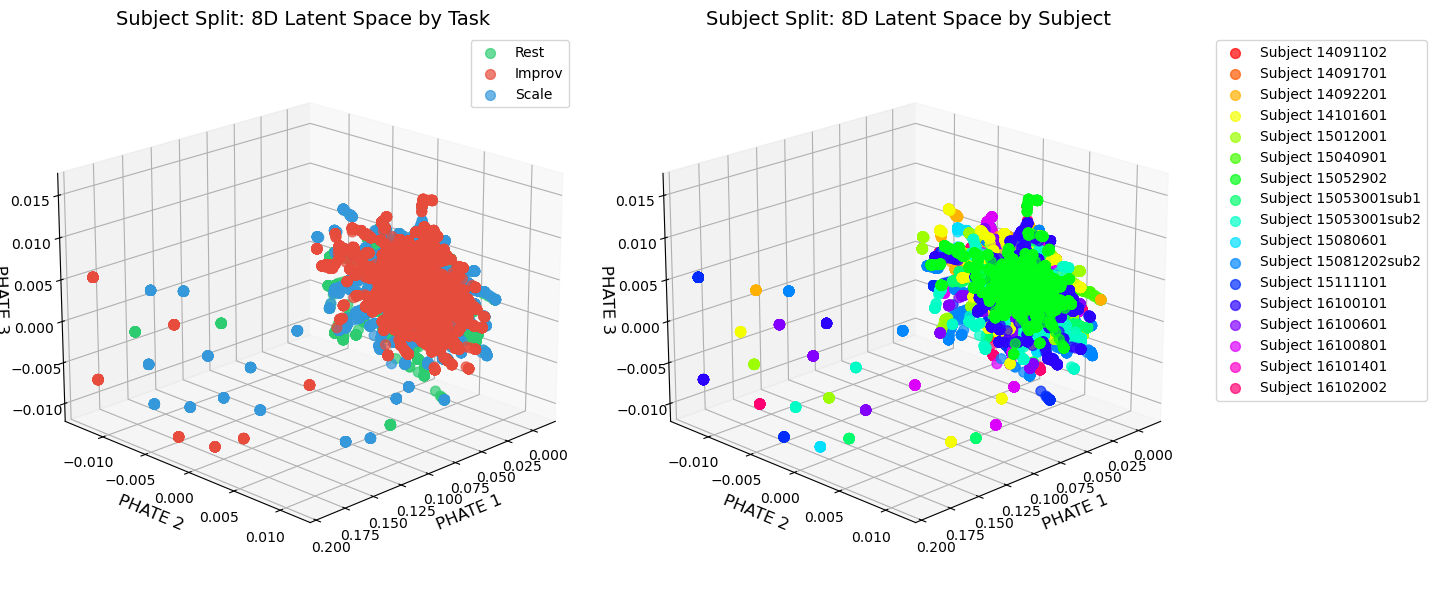

Filtered shape (rest excluded): (76608, 8)
PHATE embedding for subject split, 8D latent space...
Calculating PHATE...
  Running PHATE on 76608 observations and 8 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 3.13 seconds.
    Calculating affinities...
    Calculated affinities in 0.14 seconds.
  Calculated graph and diffusion operator in 3.28 seconds.
  Calculating landmark operator...
    Calculating SVD...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 49977 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated SVD in 1.71 seconds.
    Calculating KMeans...
    Calculated KMeans in 33.49 seconds.
  Calculated landmark operator in 36.11 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.45 seconds.
  Calculating metric MDS...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 72.53 seconds.
Calculated PHATE in 112.37 seconds.


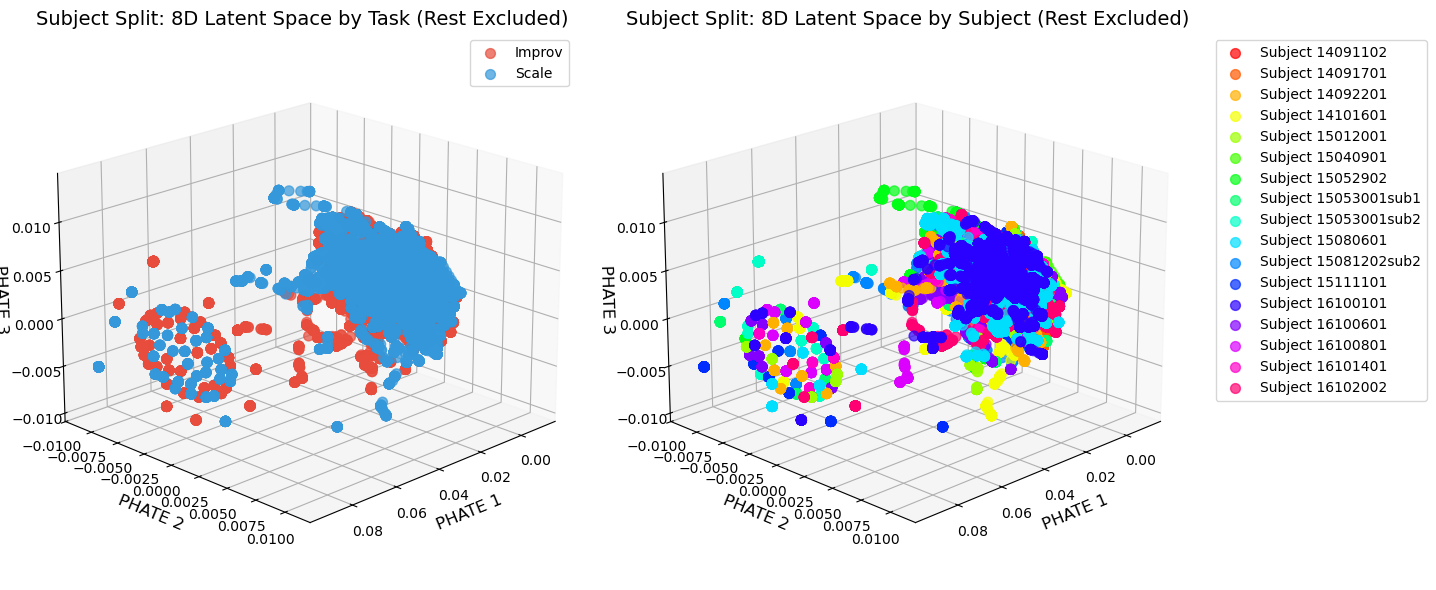

\Starting time-withheld visualizations...
PHATE embedding for time split, 8D latent space...
Calculating PHATE...
  Running PHATE on 122400 observations and 8 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 8.02 seconds.
    Calculating affinities...
    Calculated affinities in 0.20 seconds.


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 58804 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


  Calculated graph and diffusion operator in 8.24 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.74 seconds.
    Calculating KMeans...
    Calculated KMeans in 53.70 seconds.
  Calculated landmark operator in 57.86 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.48 seconds.
  Calculating metric MDS...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 73.23 seconds.
Calculated PHATE in 139.81 seconds.


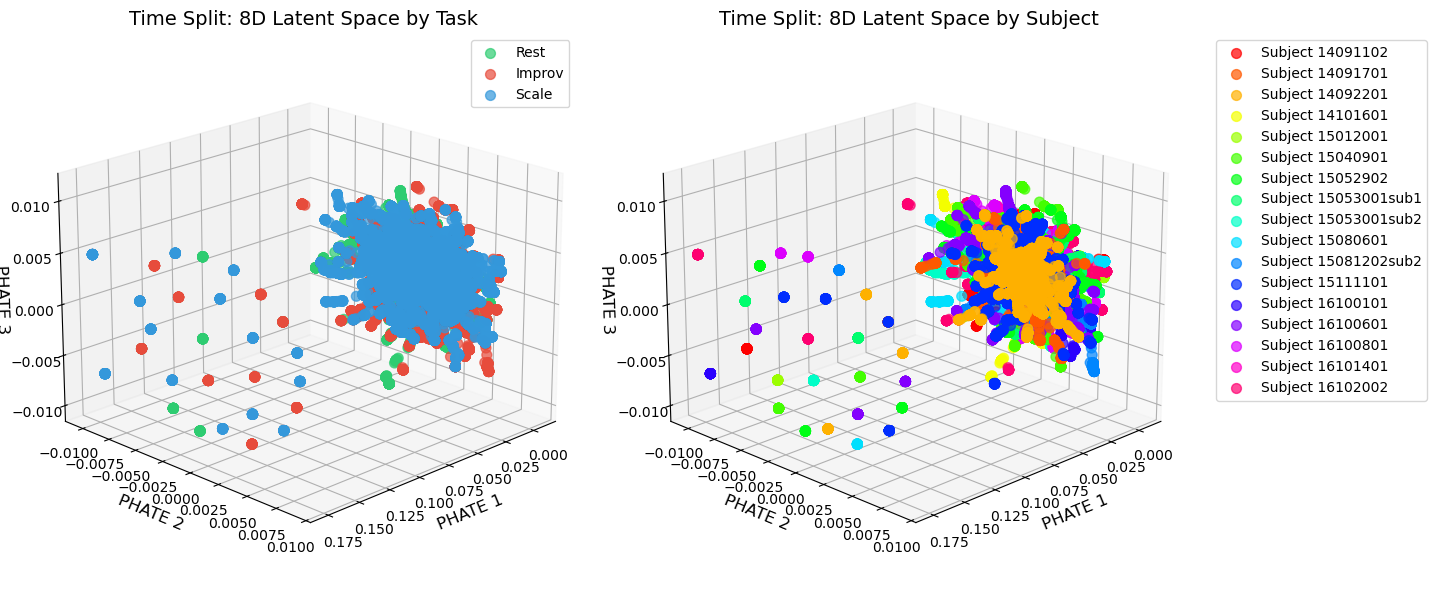

Filtered shape (rest excluded): (76092, 8)
PHATE embedding for time split, 8D latent space...
Calculating PHATE...
  Running PHATE on 76092 observations and 8 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 3.51 seconds.
    Calculating affinities...
    Calculated affinities in 0.14 seconds.
  Calculated graph and diffusion operator in 3.67 seconds.
  Calculating landmark operator...
    Calculating SVD...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 48890 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated SVD in 1.84 seconds.
    Calculating KMeans...
    Calculated KMeans in 32.60 seconds.
  Calculated landmark operator in 35.31 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.44 seconds.
  Calculating metric MDS...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 73.92 seconds.
Calculated PHATE in 113.35 seconds.


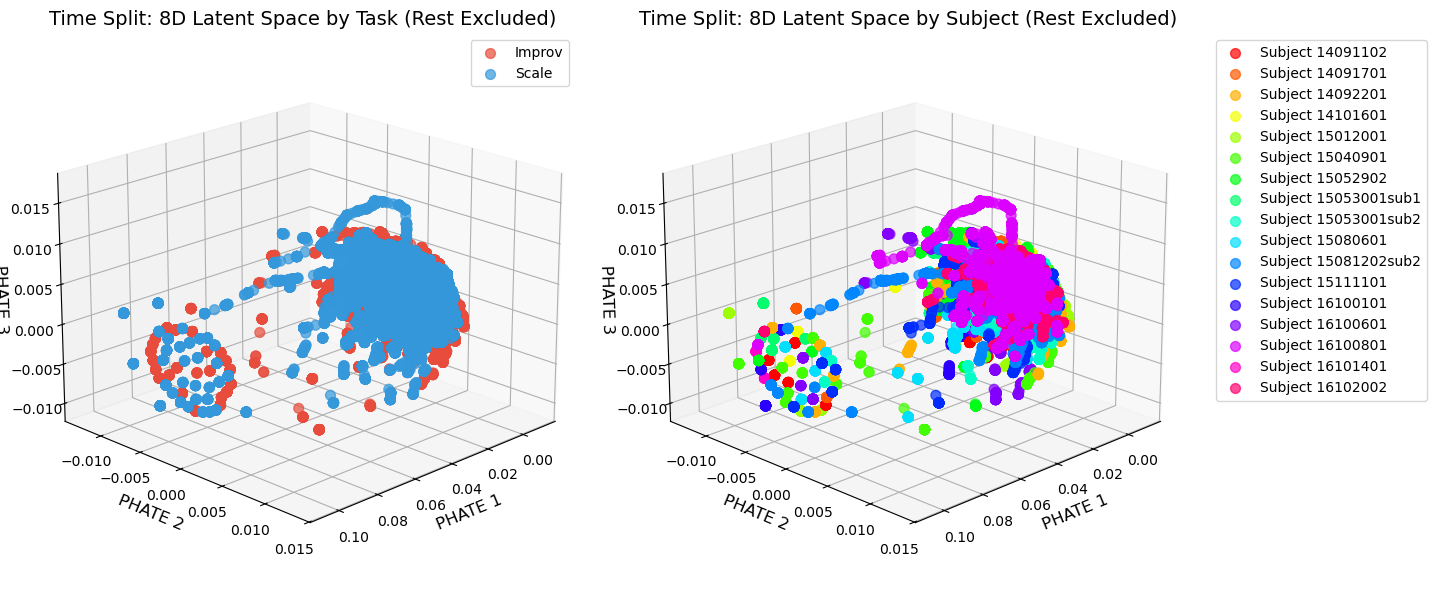


=== Visualizing 48D Latent Space ===
Starting subject-withheld visualizations...
PHATE embedding for subject split, 48D latent space...
Calculating PHATE...
  Running PHATE on 122400 observations and 48 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 37.31 seconds.
    Calculating affinities...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 60318 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated affinities in 0.21 seconds.
  Calculated graph and diffusion operator in 37.55 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.75 seconds.
    Calculating KMeans...
    Calculated KMeans in 62.06 seconds.
  Calculated landmark operator in 66.10 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.37 seconds.
  Calculating metric MDS...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 70.99 seconds.
Calculated PHATE in 175.01 seconds.


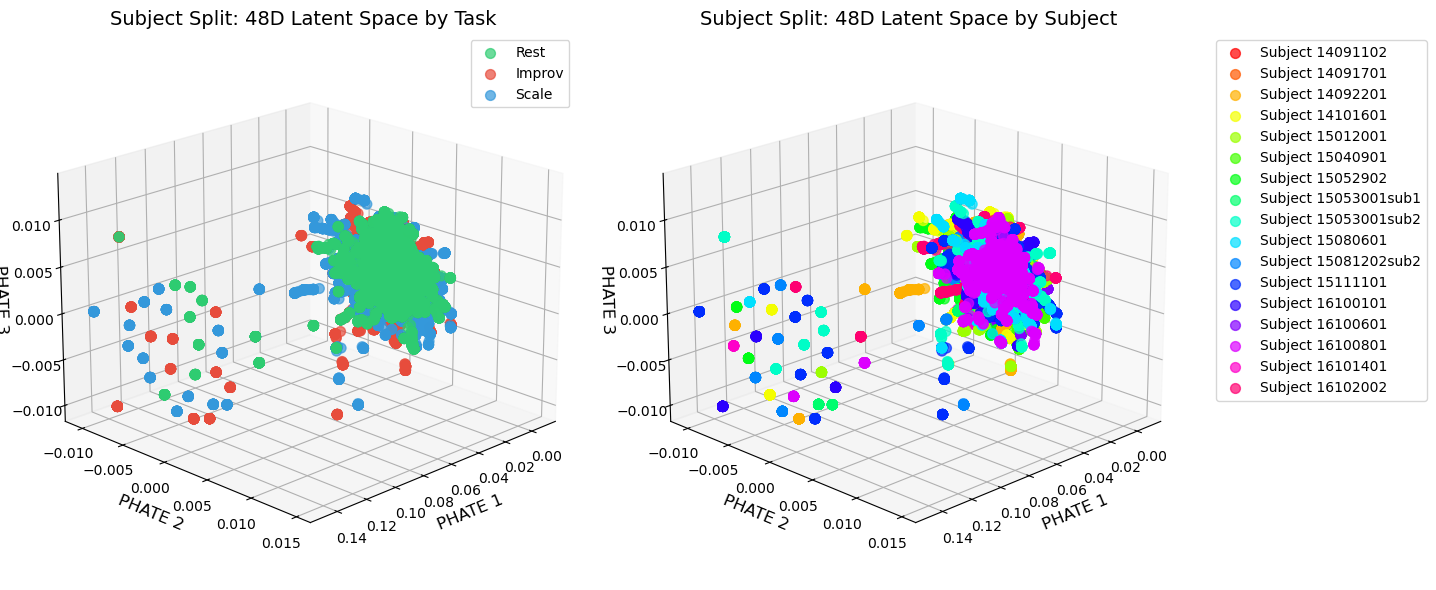

Filtered shape (rest excluded): (76516, 48)
PHATE embedding for subject split, 48D latent space...
Calculating PHATE...
  Running PHATE on 76516 observations and 48 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 9.69 seconds.
    Calculating affinities...
    Calculated affinities in 0.17 seconds.
  Calculated graph and diffusion operator in 9.88 seconds.
  Calculating landmark operator...
    Calculating SVD...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 50058 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated SVD in 1.98 seconds.
    Calculating KMeans...
    Calculated KMeans in 42.52 seconds.
  Calculated landmark operator in 45.37 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.40 seconds.
  Calculating metric MDS...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 74.45 seconds.
Calculated PHATE in 130.11 seconds.


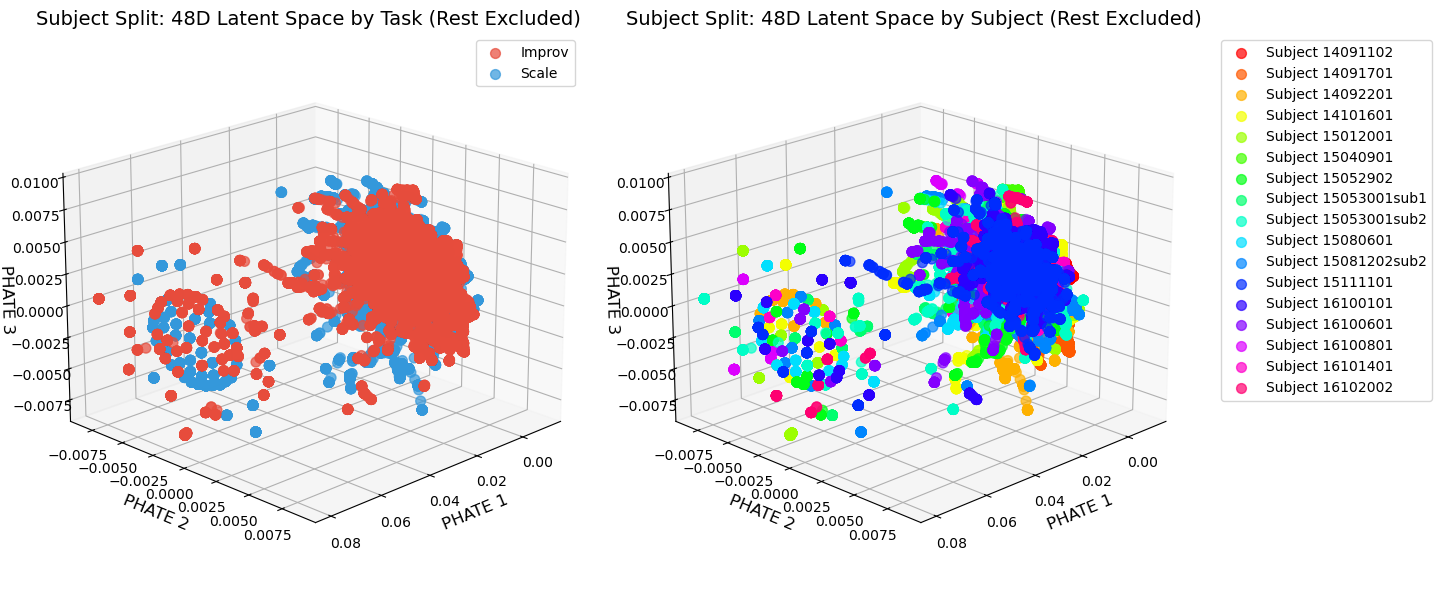

\Starting time-withheld visualizations...
PHATE embedding for time split, 48D latent space...
Calculating PHATE...
  Running PHATE on 122400 observations and 48 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 45.75 seconds.
    Calculating affinities...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 58811 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated affinities in 0.25 seconds.
  Calculated graph and diffusion operator in 46.02 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 3.26 seconds.
    Calculating KMeans...
    Calculated KMeans in 37.02 seconds.
  Calculated landmark operator in 41.67 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.45 seconds.
  Calculating metric MDS...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 73.38 seconds.
Calculated PHATE in 161.54 seconds.


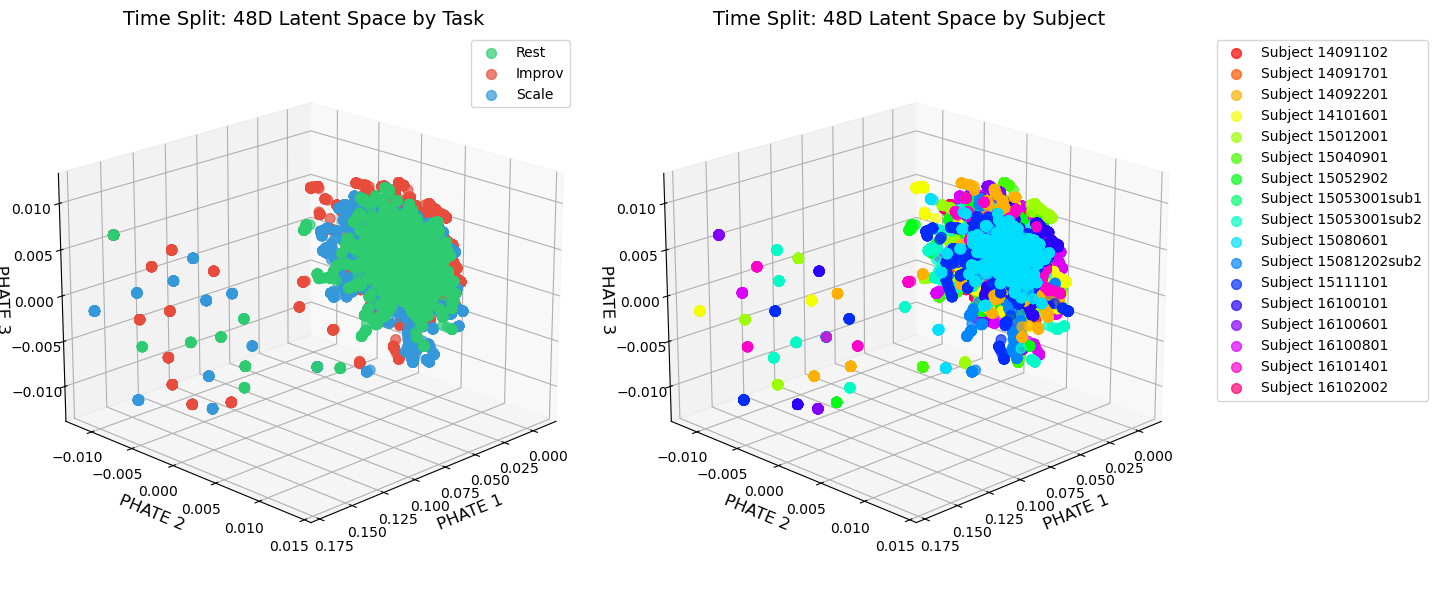

Filtered shape (rest excluded): (76106, 48)
PHATE embedding for time split, 48D latent space...
Calculating PHATE...
  Running PHATE on 76106 observations and 48 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 13.91 seconds.
    Calculating affinities...
    Calculated affinities in 0.14 seconds.
  Calculated graph and diffusion operator in 14.06 seconds.
  Calculating landmark operator...
    Calculating SVD...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 48957 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated SVD in 1.77 seconds.
    Calculating KMeans...
    Calculated KMeans in 35.74 seconds.
  Calculated landmark operator in 38.35 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.48 seconds.
  Calculating metric MDS...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 73.60 seconds.
Calculated PHATE in 126.51 seconds.


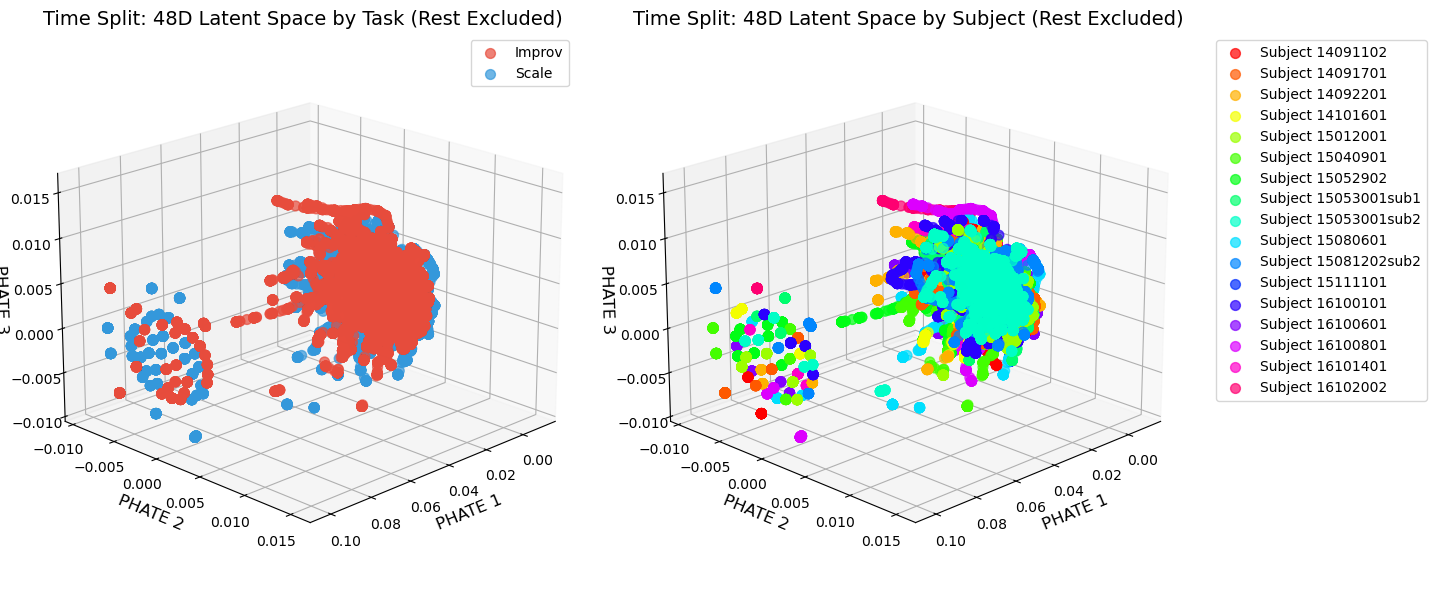

In [ ]:
### EMBED LATENT SPACES WITH PHATE ###

run_visualization = True

if run_visualization:
    latent_dims = [8, 48]
    embeddings = load_latent_embeddings(extended_results_dir, latent_dims)
    
    for latent_dim in latent_dims:
        print(f"\n=== Visualizing {latent_dim}D Latent Space ===")
        
        # Subject-withheld
        if 'subject' in embeddings[latent_dim]:
            subject_data = embeddings[latent_dim]['subject']
            print(f"Starting subject-withheld visualizations...")
            visualize_latent_space(
                subject_data['embeddings'], 
                subject_data['labels'], 
                subject_data['subjects'],
                split_type="subject", 
                latent_dim=latent_dim,
                include_rest=True
            )
            
            # W/ out rest 
            visualize_latent_space(
                subject_data['embeddings'], 
                subject_data['labels'], 
                subject_data['subjects'],
                split_type="subject", 
                latent_dim=latent_dim,
                include_rest=False
            )
        
        # Time-withheld
        if 'time' in embeddings[latent_dim]:
            time_data = embeddings[latent_dim]['time']
            print(f"\Starting time-withheld visualizations...")
            visualize_latent_space(
                time_data['embeddings'], 
                time_data['labels'], 
                time_data['subjects'],
                split_type="time", 
                latent_dim=latent_dim,
                include_rest=True
            )
            
            # W/ out rest 
            visualize_latent_space(
                time_data['embeddings'], 
                time_data['labels'], 
                time_data['subjects'],
                split_type="time", 
                latent_dim=latent_dim,
                include_rest=False
            )
else:
    print("Skipping latent space visualization")

/var/folders/wq/qc5c6y6n0y96dck20g1j0dnw0000gn/T/ipykernel_12656/179814237.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  subject_results = torch.load(subject_path, ma


=== LOADED ATTENTION MODEL RESULTS ===
Subject-withheld accuracy: 52.24%
Time-withheld accuracy: 61.18%


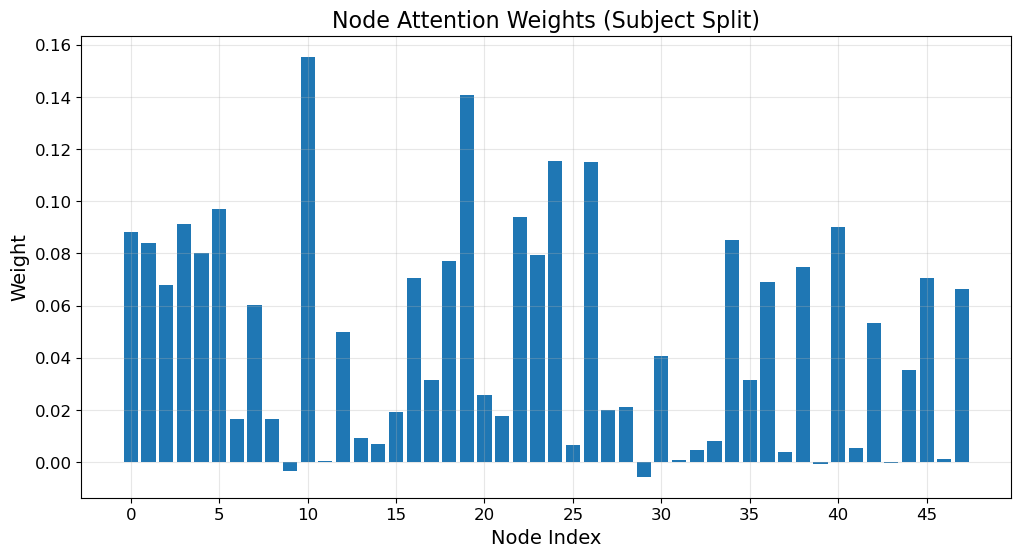

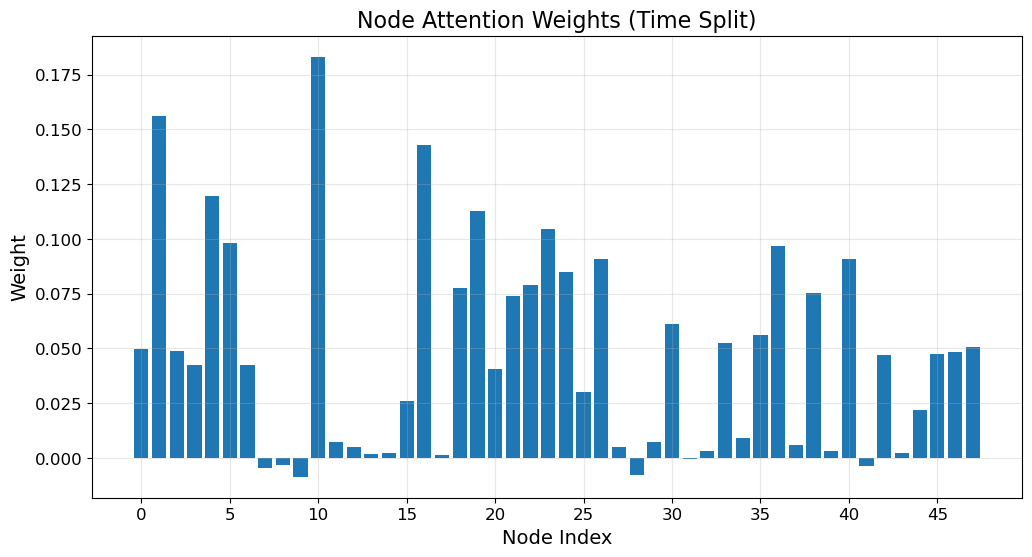

Loaded PCA loadings with shape (48, 48)

Correlation between subject and first PC loadings: -0.0209


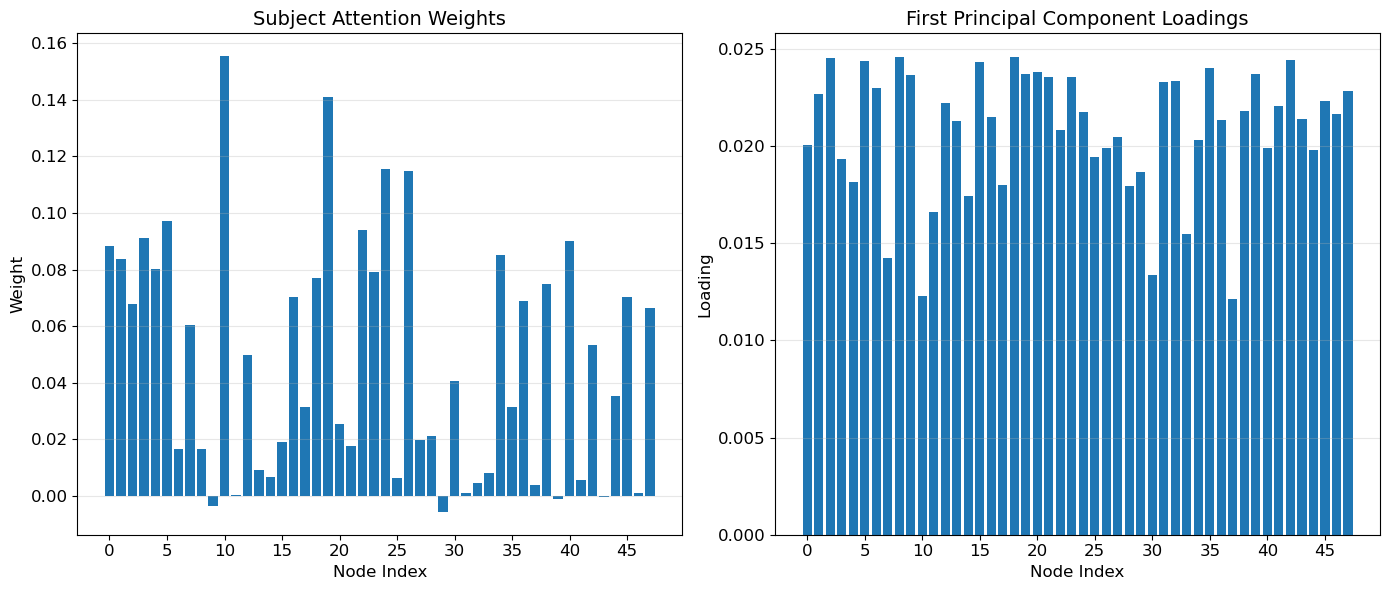


Common top nodes: [5]

Correlation between time and first PC loadings: 0.0081


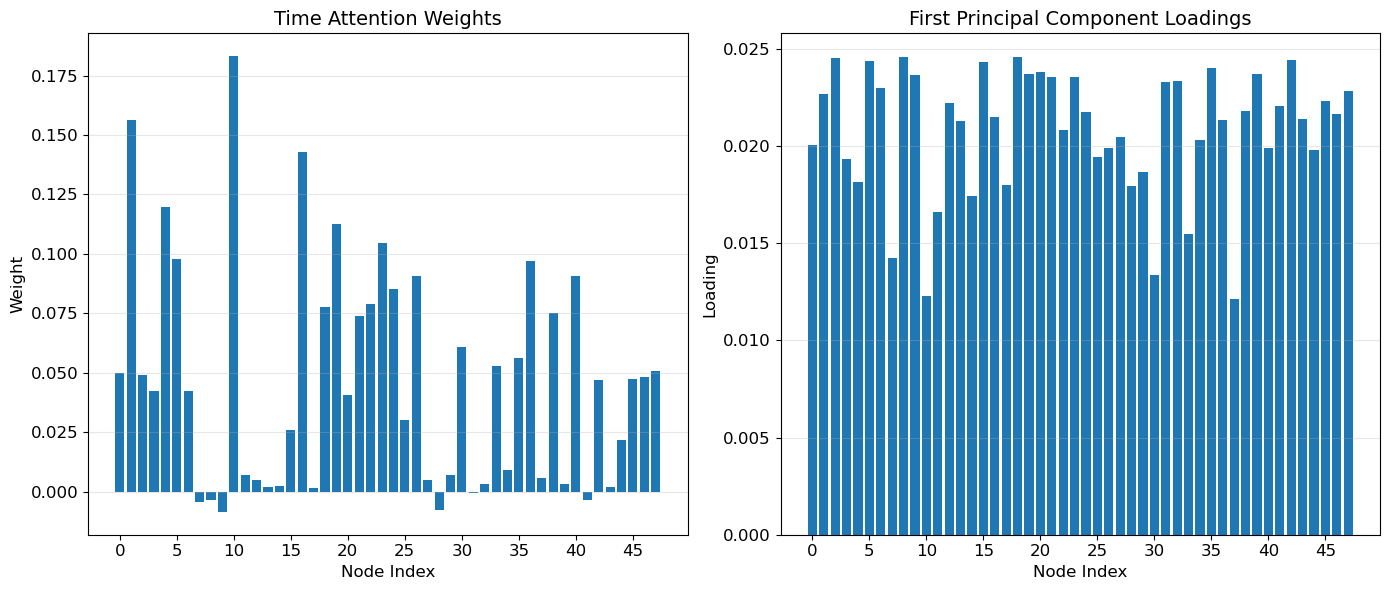


Common top nodes: []

Top 5 nodes by attention (subject): [10 19 24 26  5]
Top 5 nodes by attention (time): [10  1 16  4 19]
Top 5 nodes by PCA: [ 8 18  2 42  5]

Correlation between subject & time attention weights: 0.7591


In [ ]:
### ATTENTION ON NODES ###
run_attention = False
compare_pca = True

if run_attention:
    print("\n --- TRAINING ATTENTION MODELS ---")
    
    print("\n--- SUBJECT WITHHOLDING ---")
    subject_train_loader, subject_test_loader, (subject_train_ids, subject_test_ids) = prepare_data_for_autoencoder(
        data_path=scattering_data,
        split_type="subject"
    )
    subject_model, subject_history = train_attention_model(
        train_loader=subject_train_loader,
        test_loader=subject_test_loader,
        num_epochs=50,
        latent_dim=48, 
        split_name="SUBJECT-WITHHELD"
    )
    plot_attention_weights(subject_history['attention_weights'][-1], split_type="subject")

    torch.save({
        'model_state_dict': subject_model.state_dict(),
        'history': subject_history,
        'train_subjects': subject_train_ids,
        'test_subjects': subject_test_ids,
        'split_type': 'subject'
    }, os.path.join(attention_results_dir, 'subject_withheld_attention_model.pth'))
    print(f"Model saved to {attention_results_dir}/subject_withheld_attention_model.pth")

   
    print("\n--- TIME WITHHOLDING ---")
    time_train_loader, time_test_loader, (time_train_ids, time_test_ids) = prepare_data_for_autoencoder(
        data_path=scattering_data,
        split_type="time"
    )
    time_model, time_history = train_attention_model(
        train_loader=time_train_loader,
        test_loader=time_test_loader,
        num_epochs=50,
        latent_dim=48,
        split_name="TIME-WITHHELD"
    )
    plot_attention_weights(time_history['attention_weights'][-1], split_type="time")

    torch.save({
        'model_state_dict': time_model.state_dict(),
        'history': time_history,
        'train_subjects': time_train_ids,
        'test_subjects': time_test_ids,
        'split_type': 'time'
    }, os.path.join(attention_results_dir, 'time_withheld_attention_model.pth'))
    print(f"Model saved to {attention_results_dir}/time_withheld_attention_model.pth")

    # Summary
    print("\n=== ATTENTION MODEL RESULTS ===")
    print(f"Subject-withheld accuracy: {subject_history['test_accuracy']:.2f}%")
    print(f"Time-withheld accuracy: {time_history['test_accuracy']:.2f}%")

else:
    subject_path = os.path.join(attention_results_dir, 'subject_withheld_attention_model.pth')
    time_path = os.path.join(attention_results_dir, 'time_withheld_attention_model.pth')

    if os.path.exists(subject_path) and os.path.exists(time_path):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        subject_results = torch.load(subject_path, map_location=device)
        time_results = torch.load(time_path, map_location=device)

        print("\n=== LOADED ATTENTION MODEL RESULTS ===")
        print(f"Subject-withheld accuracy: {subject_results['history']['test_accuracy']:.2f}%")
        print(f"Time-withheld accuracy: {time_results['history']['test_accuracy']:.2f}%")
        plot_attention_weights(subject_results['history']['attention_weights'][-1], split_type="subject")
        plot_attention_weights(time_results['history']['attention_weights'][-1], split_type="time")

    else:
        print("No saved attention models found")

if compare_pca and (run_attention or (os.path.exists(subject_path) and os.path.exists(time_path))):
    pca_dir = 'pca_results'
    pca_path = os.path.join(pca_dir, 'pca_loadings.npy')
    
    if os.path.exists(pca_path):
        pca_loadings = np.load(pca_path)
        print(f"Loaded PCA loadings with shape {pca_loadings.shape}")
        
        if run_attention:
            subject_weights = subject_history['attention_weights'][-1]
            time_weights = time_history['attention_weights'][-1]
        else:
            subject_weights = subject_results['history']['attention_weights'][-1]
            time_weights = time_results['history']['attention_weights'][-1]
        
        corr_subject, subject_top, pca_top = compare_attention_with_pca(
            subject_weights, pca_loadings, "subject", weights_viz_dir)
        
        corr_time, time_top, pca_top = compare_attention_with_pca(
            time_weights, pca_loadings, "time", weights_viz_dir)
        
        print("\nTop 5 nodes by attention (subject):", subject_top)
        print("Top 5 nodes by attention (time):", time_top)
        print("Top 5 nodes by PCA:", pca_top)
        
        # Calculate correlation between subject and time attention weights
        attn_correlation = np.corrcoef(subject_weights, time_weights)[0, 1]
        print(f"\nCorrelation between subject & time attention weights: {attn_correlation:.4f}")
        
    else:
        print(f"PCA loadings file not found at {pca_path}")


--- COMPARING BASE METHODS ---


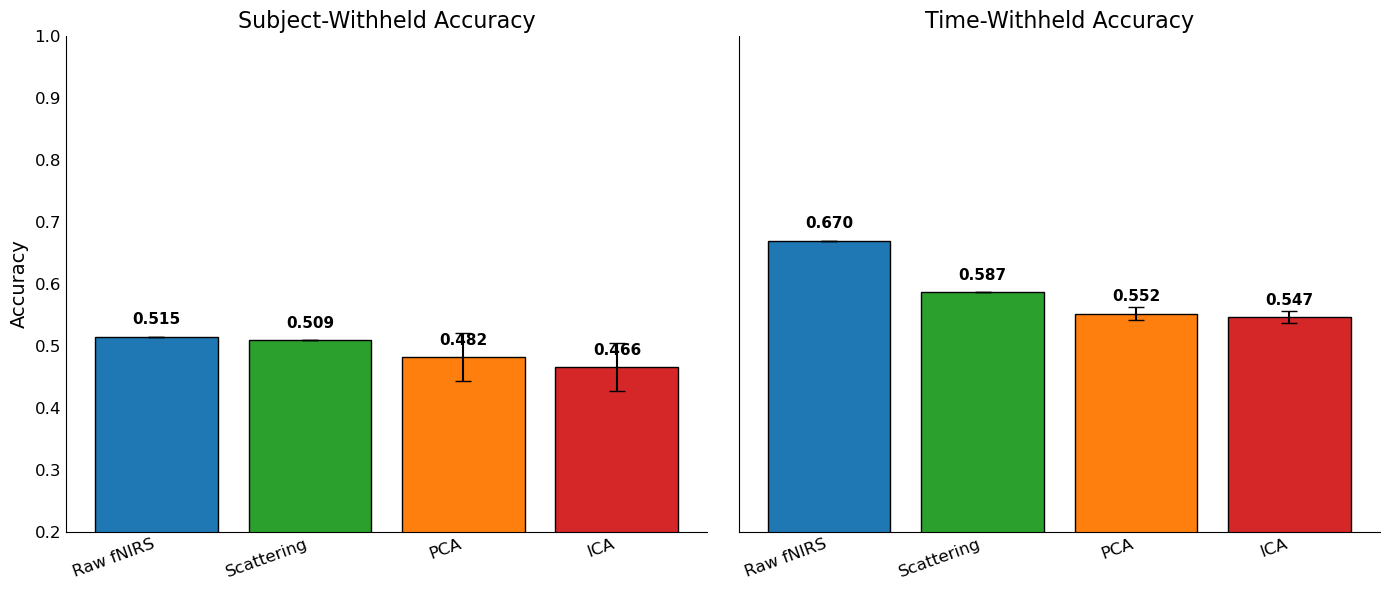

Figure saved to: /Users/judesack/THESIS_CODE/FINAL_THESIS/visualization_results/four_method_comparison.png

--- EXTENDED COMPARISON WITH LATENT SPACES ---


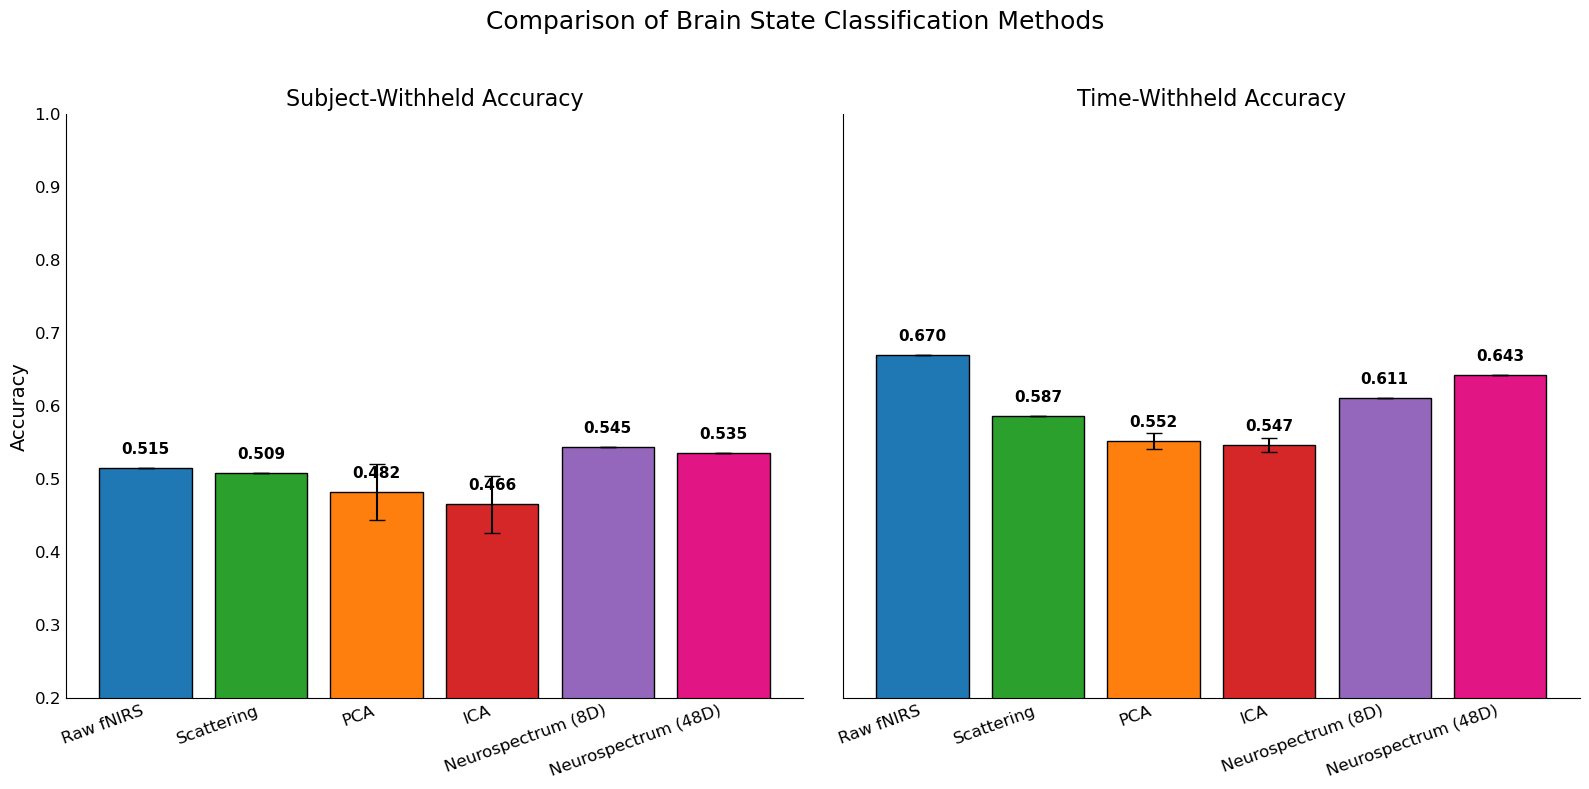

Extended latent space comparison saved to: /Users/judesack/THESIS_CODE/FINAL_THESIS/visualization_results/six_method_comparison.png

== FINAL RESULTS ==
Method               Subject-withheld     Time-withheld       
------------------------------------------------------------
Raw fNIRS            0.515 ± 0.000    0.670 ± 0.000
Scattering           0.509 ± 0.000    0.587 ± 0.000
PCA                  0.482 ± 0.038    0.552 ± 0.011
ICA                  0.466 ± 0.039    0.547 ± 0.010
Neurospectrum (8D)   0.545 ± 0.000    0.611 ± 0.000
Neurospectrum (48D)  0.535 ± 0.000    0.643 ± 0.000

=== BEST METHODS ===
Best for subject-withholding: Neurospectrum (8D) (0.5446)
Best for time-withholding: Raw fNIRS (0.6698)


In [ ]:
### CROSS-VALIDATION VISUALIZATIONS ###

# Basic comparison of the 4 methods 
print("\n--- COMPARING BASE METHODS ---")
compare_results(
    cross_validation_path='/Users/judesack/THESIS_CODE/FINAL_THESIS/cross_validation_results.pkl',
    transformed_results_path='/Users/judesack/THESIS_CODE/GSTH/notebooks/comparison_results/transformed_results.pkl',
    output_path= os.path.join('/Users/judesack/THESIS_CODE/FINAL_THESIS/visualization_results', 'four_method_comparison.png')
)

# Incl. latent spaces
print("\n--- EXTENDED COMPARISON WITH LATENT SPACES ---")
comparison_results = compare_all_methods(
    cross_validation_path='/Users/judesack/THESIS_CODE/FINAL_THESIS/cross_validation_results.pkl',
    transformed_results_path='/Users/judesack/THESIS_CODE/GSTH/notebooks/comparison_results/transformed_results.pkl',
    latent_results_dir='/Users/judesack/THESIS_CODE/FINAL_THESIS/extended_latent_results/latent_dimension_comparison.pkl',
    output_path= os.path.join('/Users/judesack/THESIS_CODE/FINAL_THESIS/visualization_results', 'six_method_comparison.png')
)

subject_methods = comparison_results['subject']['methods']
subject_means = comparison_results['subject']['means']
time_methods = comparison_results['time']['methods']
time_means = comparison_results['time']['means']
best_subject_idx = np.argmax(subject_means)
best_time_idx = np.argmax(time_means)

print("\n=== BEST METHODS ===")
print(f"Best for subject-withholding: {subject_methods[best_subject_idx]} ({subject_means[best_subject_idx]:.4f})")
print(f"Best for time-withholding: {time_methods[best_time_idx]} ({time_means[best_time_idx]:.4f})")